# Python/Tensorflow神經網路＆深度學習入門

## 03_02 Graph和Session

In [1]:
# 為了同時支援python2和python3
from __future__ import division, print_function, unicode_literals

import sys, os
print("Python Version: ", sys.version)

import numpy as np
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)

Python Version:  3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Tensorflow Version:  1.8.0


### Graph

我們在Graph上，事先決定Neurel Network的結構，決定Neuron要怎麼連接？決定哪一些窗口是可以由外部置放數據的？決定哪一些變數是可以被訓練的？哪一些變數是不可以被訓練的？定義將要怎麼樣優化這個系統？...等等。

實作一個簡單的Graph，下面採用直接創造的方法，

In [2]:
x = tf.constant([1, 2, 3])
y = tf.constant([4, 5, 6])
z = tf.add(x, y)
print(z)

Tensor("Add:0", shape=(3,), dtype=int32)


也可以簡單這樣寫

In [3]:
x = tf.constant([1, 2, 3])
y = tf.constant([4, 5, 6])
z = x + y
print(z)

Tensor("add:0", shape=(3,), dtype=int32)


與Numpy來做比較，會發現操作方式看起來類似，但是Tensorflow似乎沒有真正的去計算值。原因在於在Graph的階段，我們只有將計算的架構定出來，但是還沒有真正的計算發生。

In [4]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.add(a, b)
print(c)

[5 7 9]


In [5]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = a + b
print(c)

[5 7 9]


上面這個操作其實是默默的在`default_graph`裡建製，Tensorflow的任何操作都是指向`default`的，不管是建構階段的Graph，還有在執行階段的Session，都是操作在`default_graph`和`default_session`上，所以要特別時時注意自己目前的`default`是誰。

In [6]:
print(x.graph is tf.get_default_graph())

True


我個人的習慣是把要操作的Graph表明清楚，所以我會推薦以下寫法。

In [7]:
myGraph = tf.Graph()
with myGraph.as_default():
    x = tf.constant([1, 2, 3])
    y = tf.constant([4, 5, 6])
    z = x + y
    print(x.graph is tf.get_default_graph())

print(x.graph is tf.get_default_graph())
print(x.graph is myGraph)

True
False
True


### 使用Tensorboard來幫助我們將Graph視覺化

想要開啟Tensorboard，請回到終端機，建立好待會要將資料儲存的位置，以及啟動Tensorboard。
```
$ mkdir tf_logs
$ tensorboard --logdir tf_logs/
```

接下來就可以用瀏覽器從內網開啟Tensorboard介面，網址：[http://0.0.0.0:6006/](http://0.0.0.0:6006/)

Tensorboard的資訊會每隔一段時間自動更新，但是更新速度真的不快，所以我建議大家，打開瀏覽器的Console，並輸入以下命令來加速更新的頻率。
```
setInterval(function() {document.getElementById('reload-button').click()}, 5000);
```

接下來回到Jupyter-Notebook，我們需要利用Tensorflow將資訊導到剛剛建立好的空資料夾。

In [8]:
def get_logdir():
    from datetime import datetime
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    logdir = "{}/run-{}/".format(root_logdir, now)
    return logdir

myGraph = tf.Graph()
with myGraph.as_default():
    x = tf.constant([1, 2, 3])
    y = tf.constant([4, 5, 6])
    z = x + y
    
    logdir = get_logdir()
    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

回到瀏覽器重新更新，就可以看到剛剛所建立的Graph。

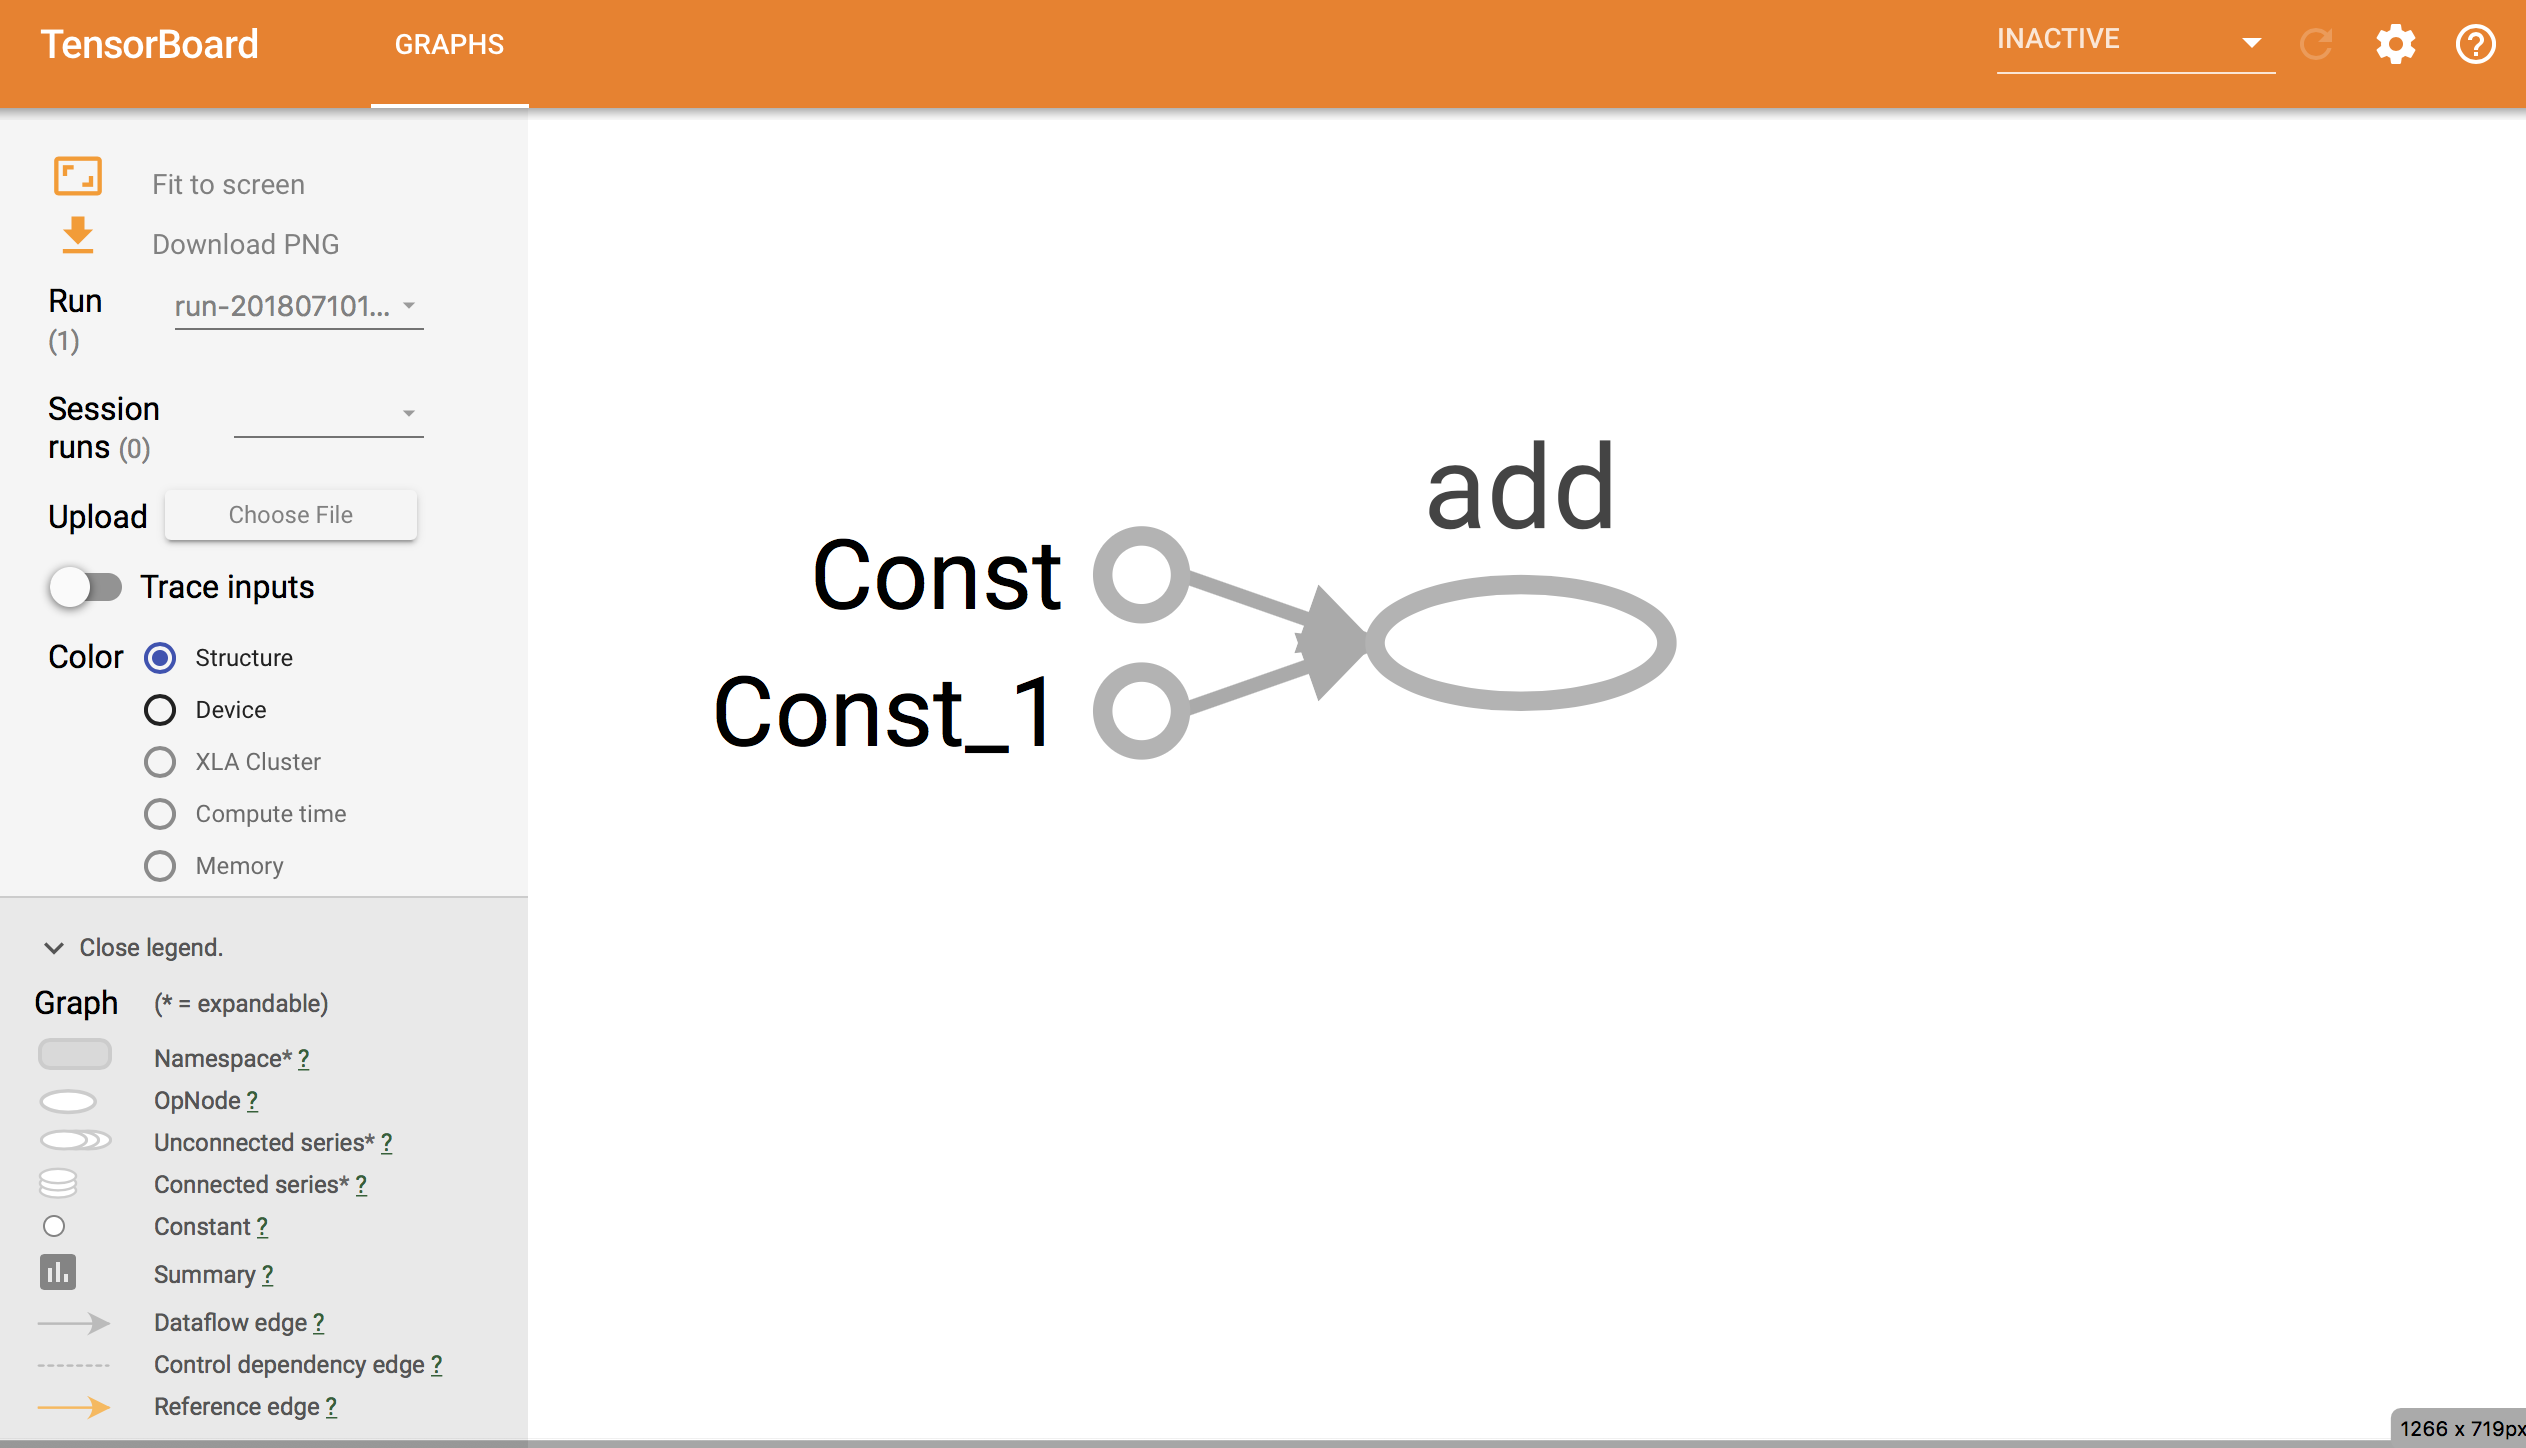

### Session

Graph只是一個結構，它不具有有效的資訊，而當我們定義完成Graph之後，接下來我們需要創造一個環境叫做Session，Session會將Graph的結構複製一份，然後再放入資訊進行Training或是預測等等。

如果要讓Graph真正跑起來，我們就需要來到執行階段。

In [9]:
with tf.Session(graph=myGraph) as sess:
    result = sess.run(z) 
    print(result)

[5 7 9]


或者也可以寫成這樣比較簡潔。

In [10]:
with tf.Session(graph=myGraph) as sess:
    result = z.eval()
    print(result)

[5 7 9]


在`with`內部的操作，Tensorflow都會自動呼叫`default_session`，像是剛剛的`sess.run(z)`或`z.eval()`，其實是執行了`tf.get_default_session().run(z)`。

不過事實上，我並不喜歡使用上面的方法呼叫Session，我會推薦以下方法，

In [11]:
mySess = tf.Session(graph=myGraph)
result = mySess.run(z)
print(result)
mySess.close()

[5 7 9]


或者

In [12]:
mySess = tf.Session(graph=myGraph)
with mySess.as_default() as sess:
    result = sess.run(z)
    print(result)
mySess.close()

[5 7 9]


如此一來，除了可以表明Session，還可以讓我們未來可以動態的操作Session。

### Node Value的生命週期

我們使用Session來執行Graph，唯有在Session裡頭，Graph才具有真正的數值，這個數值我們稱為Node Value，所以理所當然的，Node Value一定開始於Session生成，而死於Session結束，一旦Session結束，裡面所有的數值都會清空，也就無法再被取用。

In [13]:
mySess = tf.Session(graph=myGraph)
with mySess.as_default() as sess:
    result = sess.run(z)
    print(sess._closed)
    
mySess.close()
print(mySess._closed)

False
True


### 結論

* Graph和Session的用法

In [14]:
myGraph = tf.Graph()
with myGraph.as_default():
    x = tf.constant([1, 2, 3])
    y = tf.constant([4, 5, 6])
    z = x + y

mySess = tf.Session(graph=myGraph)
result = mySess.run(z)
print(result)
mySess.close()

[5 7 9]


* Tensorboard可以幫助我們視覺化Graph
* Node Value的生命週期隨Session結束而消失